# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14352578976366228065
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5356661510083045832
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 23:52:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    35W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'ResNet50'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 7
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4", "S5", "S6"
T_all_labels = "T0", "T1", "T2", "T3", "T4", "T5", "T6"

#base_path = ''
base_path = 'gdrive/My Drive/Research_7_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_ResNet50_None S_ResNet50_imagenet T_ResNet50_None T_ResNet50_imagenet


['S_ResNet50_imagenet',
 'S_ResNet50_None',
 'T_ResNet50_imagenet',
 'T_ResNet50_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2358, 128, 128, 3) (2358, 1)
(786, 128, 128, 3) (786, 1)
(786, 128, 128, 3) (786, 1)

(2598, 128, 128, 3) (2598, 1)
(866, 128, 128, 3) (866, 1)
(866, 128, 128, 3) (866, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2358, 128, 128, 3) (2358, 7)
(786, 128, 128, 3) (786, 7)
(786, 128, 128, 3) (786, 7)

(2598, 128, 128, 3) (2598, 7)
(866, 128, 128, 3) (866, 7)
(866, 128, 128, 3) (866, 7)


## 2-2. Image Check

xTrain_S image Numbers :  2358
xTrain_S image Numbers // 10 :  235
11


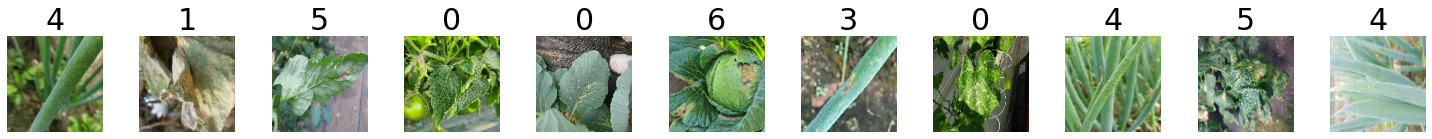

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2598
xTrain_S image Numbers // 10 :  259
11


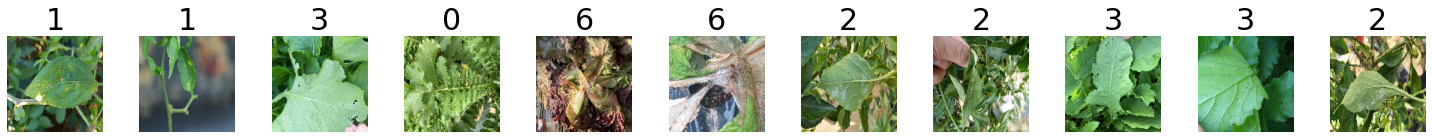

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.ResNet50 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.ResNet50 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 23s 198ms/step - loss: 1.9081 - accuracy: 0.3919 - val_loss: 2.8111 - val_accuracy: 0.1527
Epoch 2/100
37/37 [==============================] - 5s 142ms/step - loss: 1.0915 - accuracy: 0.6306 - val_loss: 2.1110 - val_accuracy: 0.3053
Epoch 3/100
37/37 [==============================] - 5s 139ms/step - loss: 0.8916 - accuracy: 0.7002 - val_loss: 2.8479 - val_accuracy: 0.1450
Epoch 4/100
37/37 [==============================] - 5s 138ms/step - loss: 0.6626 - accuracy: 0.7841 - val_loss: 4.9004 - val_accuracy: 0.1196
Epoch 5/100
37/37 [==============================] - 5s 139ms/step - loss: 0.5117 - accuracy: 0.8223 - val_loss: 3.0920 - val_accuracy: 0.2214
Epoch 6/100
37/37 [==============================] - 5s 138ms/step - loss: 0.4524 - accuracy: 0.8388 - val_loss: 3.0604 - val_accuracy: 0.2176
Epoch 7/100
37/37 [==============================] - 5s 138ms/step - loss: 0.4300 - accuracy: 0.8554 - val_loss: 5.2275 - val_accuracy: 0.080

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.908098,0.391858,2.811133,0.152672
1,1.091538,0.630619,2.111018,0.305344
2,0.891553,0.700170,2.847949,0.145038
3,0.662649,0.784139,4.900441,0.119593
4,0.511663,0.822307,3.091962,0.221374
...,...,...,...,...
95,0.028473,0.991518,1.128502,0.770992
96,0.011009,0.998304,0.874150,0.826972
97,0.008637,0.997031,0.562257,0.888041
98,0.008245,0.997455,0.466326,0.907125


Minimum validation loss: 0.4255938231945038
Maximum validation accuracy: 0.9147582650184631


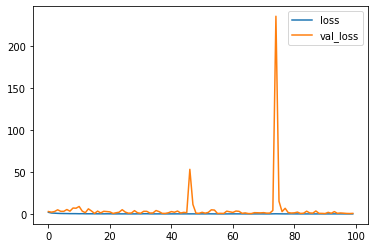

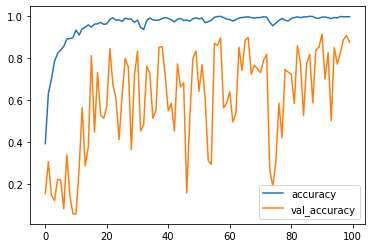

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
25/25 [==============================] - 1s 27ms/step - loss: 0.6871 - accuracy: 0.8588
test loss, test acc: [0.687134861946106, 0.8587786555290222]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

25/25 [==============================] - 2s 23ms/step


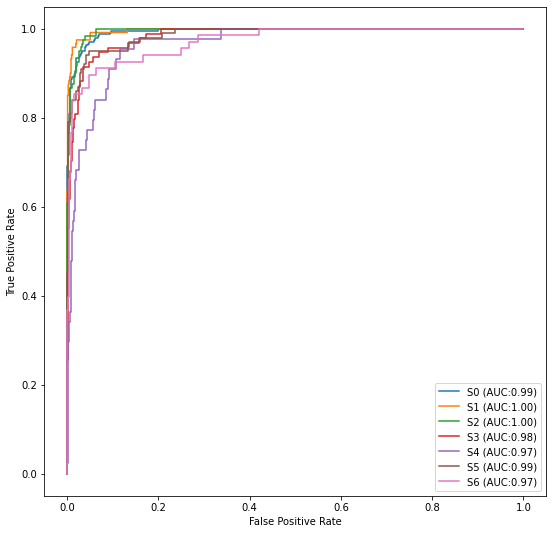

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

94781440/94765736 [==============================] - 1s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 13s 180ms/step - loss: 0.6000 - accuracy: 0.8198 - val_loss: 498.7048 - val_accuracy: 0.0560
Epoch 2/100
37/37 [==============================] - 5s 143ms/step - loss: 0.3963 - accuracy: 0.8851 - val_loss: 73.9193 - val_accuracy: 0.0865
Epoch 3/100
37/37 [==============================] - 5s 139ms/step - loss: 0.2974 - accuracy: 0.9037 - val_loss: 38.7523 - val_accuracy: 0.0560
Epoch 4/100
37/37 [==============================] - 5s 139ms/step - loss: 0.1730 - accuracy: 0.9406 - val_loss: 7.5295 - val_accuracy: 0.0560
Epoch 5/100
37/37 [==============================] - 5s 142ms/step - loss: 0.0921 - accuracy: 0.9640 - val_loss: 5.2415 - val_accuracy: 0.1196
Epoch 6/100
37/37 [==============================] - 5s 140ms/step - loss: 0.0693 - accuracy: 0.9775 - val_loss: 8.3074 - val_accuracy: 0.1196
Epoch 7/100
37/37 [==============================] - 5s 143ms/step - loss: 0.1049 - accuracy: 0.9678 - val_loss: 3.4103 - val_accuracy: 0

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.600004,0.819763,498.704834,0.055980
1,0.396278,0.885072,73.919350,0.086514
2,0.297430,0.903732,38.752300,0.055980
3,0.172984,0.940628,7.529524,0.055980
4,0.092116,0.963952,5.241513,0.119593
5,0.069341,0.977523,8.307440,0.119593
6,0.104860,0.967769,3.410316,0.152672
7,0.046624,0.986429,4.700849,0.152672
8,0.047178,0.988974,5.159248,0.152672
9,0.038328,0.991094,9.279186,0.152672


Minimum validation loss: 0.1279251128435135
Maximum validation accuracy: 0.9669210910797119


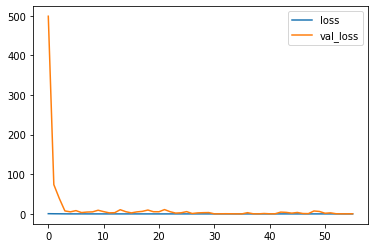

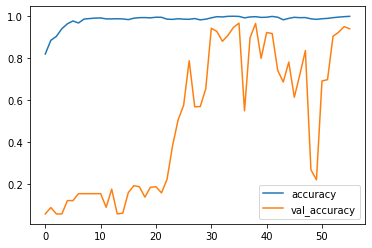

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
25/25 [==============================] - 1s 27ms/step - loss: 0.2156 - accuracy: 0.9491
test loss, test acc: [0.21556444466114044, 0.9491094350814819]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

25/25 [==============================] - 2s 23ms/step


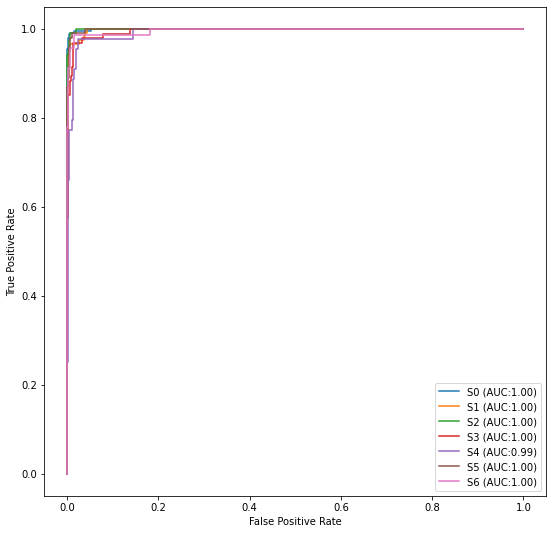

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 14s 187ms/step - loss: 1.7012 - accuracy: 0.3564 - val_loss: 2.5322 - val_accuracy: 0.0785
Epoch 2/100
41/41 [==============================] - 6s 141ms/step - loss: 1.1868 - accuracy: 0.5450 - val_loss: 2.8395 - val_accuracy: 0.1155
Epoch 3/100
41/41 [==============================] - 6s 138ms/step - loss: 0.9918 - accuracy: 0.6413 - val_loss: 4.4309 - val_accuracy: 0.1155
Epoch 4/100
41/41 [==============================] - 6s 138ms/step - loss: 0.8402 - accuracy: 0.6982 - val_loss: 8.3097 - val_accuracy: 0.1155
Epoch 5/100
41/41 [==============================] - 6s 140ms/step - loss: 0.7198 - accuracy: 0.7467 - val_loss: 8.2726 - val_accuracy: 0.1166
Epoch 6/100
41/41 [==============================] - 6s 140ms/step - loss: 0.6646 - accuracy: 0.7675 - val_loss: 2.8748 - val_accuracy: 0.2263
Epoch 7/100
41/41 [==============================] - 6s 137ms/step - loss: 0.6093 - accuracy: 0.7841 - val_loss: 3.5531 - val_accuracy: 0.217

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.701213,0.356428,2.532229,0.078522
1,1.186778,0.545035,2.839516,0.115473
2,0.991819,0.641263,4.430934,0.115473
3,0.840223,0.698229,8.309656,0.115473
4,0.719755,0.746728,8.272646,0.116628
...,...,...,...,...
77,0.008780,0.996921,1.406143,0.756351
78,0.011312,0.996151,1.306142,0.762125
79,0.049899,0.984988,2.759899,0.642032
80,0.025647,0.991532,2.587661,0.650115


Minimum validation loss: 0.8017629384994507
Maximum validation accuracy: 0.8198614120483398


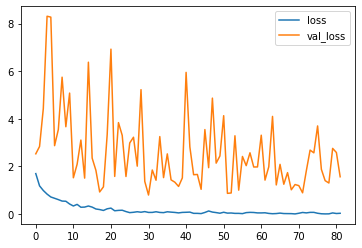

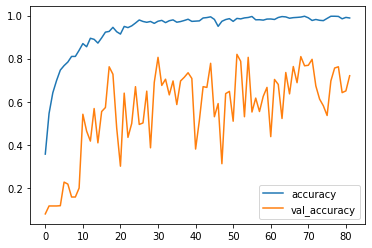

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
28/28 [==============================] - 1s 30ms/step - loss: 1.1541 - accuracy: 0.7679
test loss, test acc: [1.1540528535842896, 0.7678983807563782]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

28/28 [==============================] - 2s 23ms/step


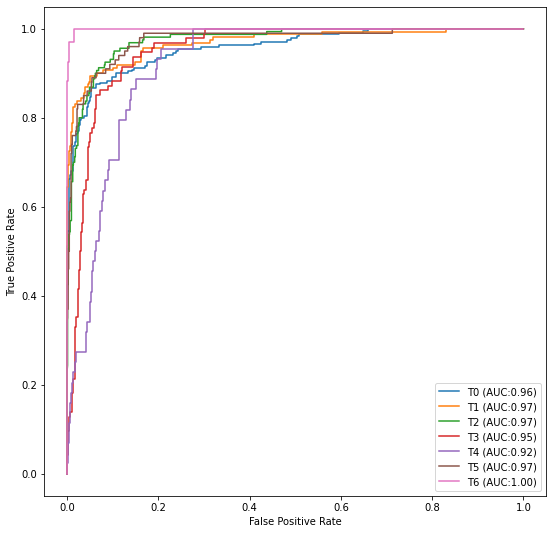

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 13s 171ms/step - loss: 0.7226 - accuracy: 0.7664 - val_loss: 6.3164 - val_accuracy: 0.1085
Epoch 2/100
41/41 [==============================] - 6s 140ms/step - loss: 0.3569 - accuracy: 0.8841 - val_loss: 383.8425 - val_accuracy: 0.1848
Epoch 3/100
41/41 [==============================] - 6s 140ms/step - loss: 0.2354 - accuracy: 0.9172 - val_loss: 96.0303 - val_accuracy: 0.2771
Epoch 4/100
41/41 [==============================] - 6s 137ms/step - loss: 0.1977 - accuracy: 0.9349 - val_loss: 11.4969 - val_accuracy: 0.2771
Epoch 5/100
41/41 [==============================] - 6s 136ms/step - loss: 0.1403 - accuracy: 0.9480 - val_loss: 3.5932 - val_accuracy: 0.1848
Epoch 6/100
41/41 [==============================] - 6s 137ms/step - loss: 0.1212 - accuracy: 0.9596 - val_loss: 4.5304 - val_accuracy: 0.1085
Epoch 7/100
41/41 [==============================] - 6s 137ms/step - loss: 0.0850 - accuracy: 0.9742 - val_loss: 5.8566 - val_accuracy: 0

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.722611,0.766359,6.316351,0.108545
1,0.356853,0.884142,383.842499,0.184758
2,0.235408,0.917244,96.030319,0.277136
3,0.197703,0.934950,11.496903,0.277136
4,0.140347,0.948037,3.593164,0.184758
5,0.121157,0.959584,4.530388,0.108545
6,0.084967,0.974211,5.856643,0.184758
7,0.120862,0.960354,15.876873,0.184758
8,0.073754,0.977290,75.090675,0.184758
9,0.102667,0.968822,2.667315,0.184758


Minimum validation loss: 0.30961158871650696
Maximum validation accuracy: 0.9191685914993286


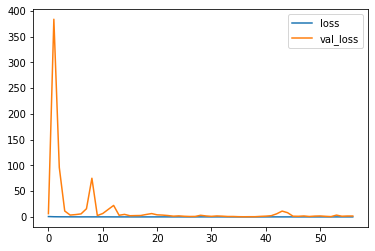

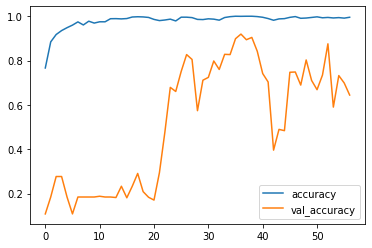

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
28/28 [==============================] - 1s 26ms/step - loss: 0.3725 - accuracy: 0.9111
test loss, test acc: [0.3724542558193207, 0.9110854268074036]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

28/28 [==============================] - 2s 23ms/step


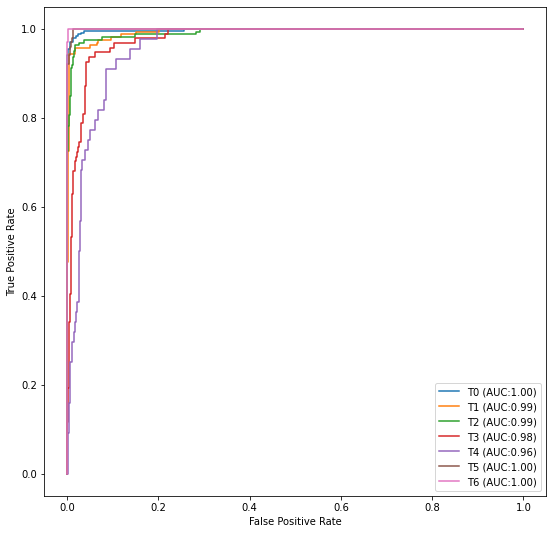

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_ResNet50_None
test loss, test acc: [0.687134861946106, 0.8587786555290222]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_ResNet50_imagenet
test loss, test acc: [0.21556444466114044, 0.9491094350814819]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_ResNet50_None
test loss, test acc: [1.1540528535842896, 0.7678983807563782]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_ResNet50_imagenet
test loss, test acc: [0.3724542558193207, 0.9110854268074036]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_ResNet50_None →→→ Target Test
28/28 [==============================] - 1s 26ms/step - loss: 7.1375 - accuracy: 0.1455
test loss, test acc: [7.137515544891357, 0.14549653232097626]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_ResNet50_imagenet →→→ Target Test
28/28 [==============================] - 1s 26ms/step - loss: 6.4214 - accuracy: 0.2113
test loss, test acc: [6.421443462371826, 0.21131639182567596]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_ResNet50_None →→→ Source Test
25/25 [==============================] - 1s 26ms/step - loss: 7.5568 - accuracy: 0.1845
test loss, test acc: [7.556792736053467, 0.18447837233543396]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_ResNet50_imagenet →→→ Source Test
25/25 [==============================] - 1s 27ms/step - loss: 5.9831 - accuracy: 0.2112
test loss, test acc: [5.983069896697998, 0.2111959308385849]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
